# Preparing data

This notebook reads data processed by Galaxy and

 1. Validates sites to ensire that coordinates are correct
 2. Adds information about variants of concern (VOC) and sites under selection


In [1]:
import pandas as pd
import seaborn as sns

In [2]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=e655a5ef5b9f777fb8d550a0a2826689f7cce243bc1ab47db2e989ca3e2bc92b
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [3]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Which dataset to run notebook on?
At this time there are three possible datasets:

 - Boston: `boston`
 - COG-Pre: `cog-pre`
 - COG-Post: `cog-post`

Setting this variable runs all notebook content for this particular dataset. The actual paths are pulled out from `datasets` dict (next cell)

In [4]:
dataset = 'cog-post'

In [5]:
datasets = {
    'boston':
        [   
            'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/var/bos_by_sample.tsv.gz',
            'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/var/bos_by_var.tsv.gz'
        ],
    'cog-pre': 
        [   
            'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/var/cog_20200917_by_sample.tsv.gz',
            'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/var/cog_20200917_by_var.tsv.gz'
        ],
    'cog-post': 
        [   
            'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/var/cog_20201120_by_sample.tsv.gz',
            'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/var/cog_20201120_by_var.tsv.gz'
        ]
}

## Load annotation datasets:

- SARS genomes as FASTA file
- Variants of concern
- Selection data

In [6]:
# SARS-CoV-2 genome assembly url
gnm_url = 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz'
gnm_file = gnm_url.split('/')[-1]
# VOC data
voc_url = 'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/voc/voc.tsv.gz'
# Selection data
sel_url = 'https://github.com/galaxyproject/SARS-CoV-2/raw/master/data/selection/selection.tsv.gz'

In [7]:
# Get SARS-CoV-2 RefSeq genomes (in GenBank format) from NCBI
import os.path
from os import path
if not path.exists(gnm_file[:-3]):
    !wget -nc {gnm_url}
    !gunzip {gnm_file}
else:
    print('File {} is already here\nDoing nothing!'.format(gnm_file))

--2021-02-25 19:57:28--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9591 (9.4K) [application/x-gzip]
Saving to: ‘GCF_009858895.2_ASM985889v3_genomic.fna.gz’

GCF_009858895.2_ASM 100%[===================>]   9.37K  --.-KB/s    in 0s      

2021-02-25 19:57:28 (187 MB/s) - ‘GCF_009858895.2_ASM985889v3_genomic.fna.gz’ saved [9591/9591]



In [8]:
seq = ""
with open(gnm_file[:-3],'r') as f:
    for line in f:
        if not line.startswith('>'):
            seq += line.rstrip()

## Load and validate the data

- Translate `FUNCLASS` names
- Convert coordinates to 0-based (because VCFs are 1-based)
- Validate all sites by comparing contains of `REF` field to genome

In [9]:
var =   pd.read_csv(datasets[dataset][0],sep='\t')
sites = pd.read_csv(datasets[dataset][1],sep='\t')

In [10]:
funclass_translation = {'SILENT':'Synonymous','MISSENSE':'Non-synonymous','NONSENSE':'Stop','.':'Non-coding','NONE':'Indel'}
var = var.replace({'FUNCLASS':funclass_translation})
sites = sites.replace({'FUNCLASS':funclass_translation})

In [11]:
# Changing coordinates to 0-based
var['POS'] = var['POS']-1
sites['POS'] = sites['POS']-1

In [12]:
# Validation function for checking against genome

def check_against_genome(seq,df,fields,name,debug=False):
    
    """ Takes sequence (seq), dataframe (df),
    names of columns containing position and reference allele
    (e.g., ['POS','REF']), and dataframe name.
    Setting debud to True outputs a list of problematic sites.

    Returns a dict with counts and list of wrong sites if any.
    """

    df.name = df
    wrong = []
    bad = 0
    good = 0
    pb = df[fields].to_numpy()
    for pos,ref in pb:
        base = seq[pos:pos+len(ref)]
        if base == ref:
            good += 1
        else:
            bad += 1
            wrong.append([pos,ref])
    if debug is True:
        return(wrong)
    else:
        return([name,good,bad,len(df)])

In [13]:
outcome = pd.DataFrame(columns=['dataset','good','bad','size'])
outcome.loc[len(outcome)] = check_against_genome(seq,var,['POS','REF'],'var')
outcome.loc[len(outcome)] = check_against_genome(seq,sites,['POS','REF'],'sites')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


In [14]:
class coordinateError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

if outcome['bad'].sum() > 0:
    raise coordinateError("{} sites were not verified. Run check_agianst_genome with debig=True".format(outcome['bad'].sum()))

## Add info about sites under selection

In [15]:
sel = pd.read_csv(sel_url,sep='\t')

In [16]:
# Add info about sites under sleection to the main variant table
sites = pysqldf('select sites.*, sel.fel_p,sel.meme_p,sel.freq from sites left join sel on sites.POS >= sel.pos and sites.POS <= sel.pos+2 ')
var = pysqldf('select var.*, sel.fel_p,sel.meme_p,sel.freq from var left join sel on var.POS >= sel.pos and var.POS <= sel.pos+2 ')

## Add information about Variants of Concern (VOCs)

In [17]:
voc = pd.read_csv(voc_url, sep='\t',names=['voc_set','mut','position'],header=None)

In [18]:
for item in voc['voc_set'].unique():
    sites = pysqldf('select sites.*, mut from sites left join voc on (POS >= position and POS < position+3) and voc_set = "{0}"'.format(item))
    sites = sites.rename(columns={"mut": item})
    var = pysqldf('select var.*, mut from var left join voc on (POS >= position and POS < position+3) and voc_set = "{0}"'.format(item))
    var = var.rename(columns={"mut": item})

## Set varinats types

In [19]:
# Assumes df has columns labelled 'ALT' and 'REF'
def chng_type(df):
    df.loc[df['REF'].str.len() == df['ALT'].str.len(), 'type'] = 'SNP'
    df.loc[df['REF'].str.len() != df['ALT'].str.len(), 'type'] = 'Indel'

In [20]:
chng_type(var)
chng_type(sites)

## Summarize

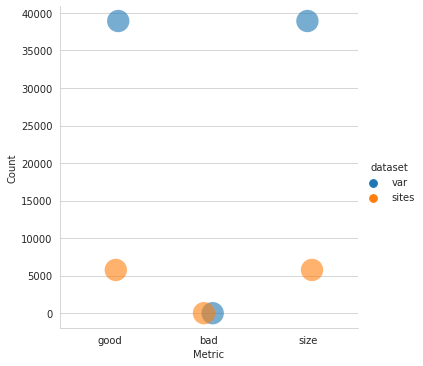

In [21]:
sns.set_style("whitegrid")
sns.catplot(
    y='Count',
    x='Metric',hue='dataset',
    sizes=(500,500),
    alpha=.6,
    data=outcome.melt(
        id_vars=['dataset'],
        value_vars=['good','bad','size'],
        value_name='Count',var_name='Metric'
        )
    )

## Add count of unqiue samples and give columns humane names

Here we add two columns to each table:

- `all_samples` - the number of samples containing a given variant at *any* frequency (even very low)
- `samples` - the number of samples containing a given varianst with a frequency above the threshold set by the Galaxy variant calling workflow (usually 5%)

In [22]:
var = var.rename(columns={'countunique(change)':'unique_change','countunique(FUNCLASS)':'unique_funclass'})

In [23]:
sample_counts = pysqldf('select POS, ALT, REF,count(*) as N from var group by POS, ALT, REF ')

In [24]:
var = pysqldf('select var.*, N as samples from var left join sample_counts on var.POS = sample_counts.POS and var.REF = sample_counts.REF and var.ALT = sample_counts.ALT')

In [25]:
sites = sites.rename(columns={'countunique(Sample)':'all_samples','min(AF)':'mAF','max(AF)':'xAF'})
var = sites.rename(columns={'min(AF)':'mAF','max(AF)':'xAF'})

In [26]:
sites['samples'] = list(map(len,sites['SAMPLES(above-thresholds)'].str.split(',')))

## Write files

In [27]:
var.to_csv('{}_by_sample_processed.tsv'.format(dataset),sep='\t',index=False)
sites.to_csv('{}_by_var_processed.tsv'.format(dataset),sep='\t',index=False)
!gzip *.tsv

In [28]:
from google.colab import files
files.download('{}_by_sample_processed.tsv.gz'.format(dataset))
files.download('{}_by_var_processed.tsv.gz'.format(dataset))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>